<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Alumno: Kurt Castro Ortega</em><br>
    <em>Tutors: PhD. Germán Gómez, PhD. Umberto Michelucci</em><br>


</div>


**Capstone Proyect - Visión Computacional**

# Comparative Analysis of CNN Architectures for Histopathology Classification

## Abstract

This notebook provides a comprehensive comparative analysis of five deep learning architectures trained for histopathological tissue classification: a custom CNN baseline, VGG19, ResNet50, EfficientNetB0, and Vision Transformer (ViT-B/16). I evaluate these models across multiple dimensions including classification performance, computational efficiency, and statistical significance of differences.

**Models Compared:**
1. **CNN Baseline (Improved)**: Custom architecture with 1.24M parameters
2. **VGG19**: Transfer learning with block5 fine-tuning
3. **ResNet50**: Transfer learning with name-based fine-tuning
4. **EfficientNetB0**: Transfer learning with compound scaling
5. **ViT-B/16**: Vision Transformer with frozen backbone (proper transfer learning)

**Dataset:** Kather et al. (2016) colorectal histopathology dataset - 8 tissue classes, 5,000 images.

**Analysis Objectives:**
- Compare test set performance across all models (CNNs vs Transformer)
- Analyze training dynamics and convergence behavior
- Evaluate computational efficiency trade-offs
- Assess statistical significance of performance differences
- Provide deployment recommendations based on use case

---

# Section 1: Setup & Configuration

I import required libraries and configure paths to pre-trained models, training histories, and test data.

## 1.1 Import Dependencies

I import standard libraries for data manipulation, visualization, statistical analysis, and deep learning model evaluation.

In [1]:
# # =============================================================================
# # GPU CONFIGURATION: Force CPU mode to avoid CuDNN errors
# # =============================================================================
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow warnings

# print("="*80)
# print("HARDWARE CONFIGURATION")
# print("="*80)
# print("  Mode: CPU-only (GPU disabled)")
# print("  Reason: Inference-only notebook - CPU is sufficient")
# print("  Expected time: ~2-5 minutes for all predictions")
# print("  Note: This avoids CuDNN/GPU driver issues during evaluation")
# print("="*80)

In [2]:
# Standard libraries
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Metrics and evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score
)

# # Statistical tests
# from scipy import stats
# from scipy.stats import mcnemar, chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar

# Custom utilities (optional - not used in this notebook)
# If needed in the future, uncomment and change to: import analysis_utils
# sys.path.append(str(Path.cwd().parent / 'src'))
# from utils import analysis_utils

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

TensorFlow version: 2.10.1
Keras version: 2.10.0
NumPy version: 1.23.5
Pandas version: 2.1.4


## 1.2 Configure Paths

I define paths to models, results, and data directories for easy access throughout the analysis.

In [3]:
# Base directories
BASE_DIR = Path.cwd().parent
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results' / 'figures'
LOGS_DIR = BASE_DIR / 'logs'
DATA_DIR = BASE_DIR / 'data' / 'processed'

# Model-specific paths
PATHS = {
    'baseline': {
        'model': MODELS_DIR / 'baseline_improved' / 'best_model.keras',
        'results': RESULTS_DIR / 'baseline_improved',
        'logs': LOGS_DIR / 'baseline_improved',
        'name': 'CNN Baseline'
    },
    'vgg19': {
        'model': MODELS_DIR / 'vgg' / 'best_vgg_model.h5',
        'results': RESULTS_DIR / 'vgg',
        'logs': LOGS_DIR / 'vgg',
        'name': 'VGG19'
    },
    'resnet50': {
        'model': MODELS_DIR / 'resnet50' / 'best_resnet_model.keras',
        'results': RESULTS_DIR / 'resnet50',
        'logs': LOGS_DIR / 'resnet50',
        'name': 'ResNet50'
    },
    'efficientnet': {
        'model': MODELS_DIR / 'efficientnet' / 'best_efficientnet_model.keras',
        'results': RESULTS_DIR / 'efficientnet',
        'logs': LOGS_DIR / 'efficientnet',
        'name': 'EfficientNetB0'
    },
    'vit_b16': {
        'model': MODELS_DIR / 'vit' / 'best_vit_model.keras',
        'results': RESULTS_DIR / 'vit',
        'logs': LOGS_DIR / 'vit',
        'name': 'ViT-B/16'
    }
}

# Test data paths
TEST_DATA_DIR = DATA_DIR / 'test'

# Class names
CLASS_NAMES = [
    '01_TUMOR',
    '02_STROMA',
    '03_COMPLEX',
    '04_LYMPHO',
    '05_DEBRIS',
    '06_MUCOSA',
    '07_ADIPOSE',
    '08_EMPTY'
]

# Verify paths exist
print("Verifying paths...")
for model_name, paths in PATHS.items():
    model_exists = paths['model'].exists()
    results_exists = paths['results'].exists()
    logs_exists = paths['logs'].exists()
    print(f"{paths['name']:20} - Model: {model_exists}, Results: {results_exists}, Logs: {logs_exists}")

print(f"\nTest data directory exists: {TEST_DATA_DIR.exists()}")

Verifying paths...
CNN Baseline         - Model: True, Results: True, Logs: True
VGG19                - Model: True, Results: True, Logs: True
ResNet50             - Model: True, Results: True, Logs: True
EfficientNetB0       - Model: True, Results: True, Logs: True
ViT-B/16             - Model: True, Results: True, Logs: True

Test data directory exists: True


## 1.3 Load Test Data

I load the test dataset that will be used to evaluate all models consistently. This ensures fair comparison across architectures.

In [4]:
# Import shared pipeline (already used in training notebooks)
import sys
sys.path.insert(0, str(BASE_DIR / 'src'))
from shared_pipeline import create_dataset, get_config, CLASS_NAMES as PIPELINE_CLASS_NAMES

def load_test_dataset(test_dir, batch_size=32, img_size=(224, 224), model_type='baseline'):
    """
    Load test dataset using shared_pipeline for consistency with training.
    """
    # Map model_type to shared_pipeline format
    model_type_map = {
        'baseline': 'baseline',
        'vgg19': 'vgg',
        'resnet50': 'resnet',
        'efficientnet': 'efficientnet',
        'vit_b16': 'vit'  # ViT uses same preprocessing as its training
    }
    pipeline_model_type = model_type_map.get(model_type, model_type)
    
    # Get config using shared_pipeline
    config = get_config(
        model_type=pipeline_model_type,
        img_size=img_size[0],  # shared_pipeline uses single int
        batch_size=batch_size,
        data_dir=str(test_dir.parent.parent)  # data/processed -> data
    )
    
    # Override data_dir to point to processed folder
    config['data_dir'] = test_dir.parent
    
    print(f"Loading test dataset for {model_type}...")
    print(f"  Image size: {config['img_height']}x{config['img_width']}")
    print(f"  Model preprocessing: {pipeline_model_type}")
    
    # Create test dataset (no augmentation, no shuffle)
    dataset = create_dataset(
        directory=test_dir,
        config=config,
        augment=False,
        shuffle=False
    )
    
    return dataset

print("Dataset loading function defined using shared_pipeline.")
print("  - CNN Baseline: 150x150, [0, 255] -> [0, 1] rescaling")
print("  - VGG19: 224x224, VGG preprocess_input")
print("  - ResNet50: 224x224, ResNet preprocess_input")
print("  - EfficientNetB0: 224x224, EfficientNet preprocess_input")
print("  - ViT-B/16: 224x224, ImageNet normalization (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])")

Dataset loading function defined using shared_pipeline.
  - CNN Baseline: 150x150, [0, 255] -> [0, 1] rescaling
  - VGG19: 224x224, VGG preprocess_input
  - ResNet50: 224x224, ResNet preprocess_input
  - EfficientNetB0: 224x224, EfficientNet preprocess_input
  - ViT-B/16: 224x224, ImageNet normalization (mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])


---
# Section 2: Load Pre-trained Models

I load the five pre-trained models (4 CNNs + 1 Transformer) and verify their architectures to ensure correct model restoration.

## 2.1 Load All Models

I load each pre-trained model from disk and display basic architecture information.

In [5]:
def load_model_safe(model_path):
    """
    Safely load a Keras model with error handling.
    Compatible with TensorFlow 2.10 (Keras 2.10).
    
    Args:
        model_path: Path to saved model file (.keras or .h5)
    
    Returns:
        model: Loaded Keras model or None if failed
    """
    try:
        # For ViT model: try loading with vit-keras custom objects
        if 'vit' in str(model_path).lower():
            try:
                # Import vit-keras to register custom layers
                import vit_keras
                from vit_keras import vit
                print("  Using vit-keras custom objects for ViT model")
            except ImportError:
                print("  Warning: vit-keras not installed, using default loader")
        
        # Load model (works for all architectures)
        model = keras.models.load_model(model_path, compile=False)
        
        # Recompile with standard settings for consistency
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    except Exception as e:
        print(f"  Error: {e}")
        return None

# Load all models
models = {}
print("Loading pre-trained models...\n")

for key, paths in PATHS.items():
    print(f"Loading {paths['name']}...")
    model = load_model_safe(paths['model'])
    
    if model is not None:
        models[key] = model
        
        # Get model info
        total_params = model.count_params()
        trainable_params = sum([keras.backend.count_params(w) for w in model.trainable_weights])
        non_trainable_params = total_params - trainable_params
        
        print(f"  ✓ Loaded successfully")
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
        print(f"  Non-trainable: {non_trainable_params:,} ({100*non_trainable_params/total_params:.2f}%)")
    else:
        print(f"  ✗ Failed to load")
    print()

print(f"\nSuccessfully loaded {len(models)}/5 models")

Loading pre-trained models...

Loading CNN Baseline...
  ✓ Loaded successfully
  Total parameters: 1,313,832
  Trainable: 1,310,888 (99.78%)
  Non-trainable: 2,944 (0.22%)

Loading VGG19...
  ✓ Loaded successfully
  Total parameters: 20,091,592
  Trainable: 9,506,184 (47.31%)
  Non-trainable: 10,585,408 (52.69%)

Loading ResNet50...
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce GTX 1650, compute capability 7.5
  ✓ Loaded successfully
  Total parameters: 27,808,648
  Trainable: 13,135,880 (47.24%)
  Non-trainable: 14,672,768 (52.76%)

Loading EfficientNetB0...
  ✓ Loaded successfully
  Total parameters: 4,709,547
  Trainable: 3,815,716 (81.02%)
  Non-trainable: 893,831 (18.98%)

Loading ViT-B/16...
  Using vit-keras custom objects for ViT model
  ✓ Loaded successfully
  Total parameters: 86,196,488
  Trainable: 397,832 (0.46%)
  Non-t

## 2.2 Model Architecture Summary

I display a comparison table of model architectures showing key structural differences.

In [6]:
# Create architecture comparison table
arch_data = []

for key, model in models.items():
    total_params = model.count_params()
    trainable_params = sum([keras.backend.count_params(w) for w in model.trainable_weights])
    
    arch_data.append({
        'Model': PATHS[key]['name'],
        'Total Layers': len(model.layers),
        'Total Parameters (M)': f"{total_params / 1e6:.2f}",
        'Trainable Parameters (M)': f"{trainable_params / 1e6:.2f}",
        'Trainable %': f"{100 * trainable_params / total_params:.2f}%",
        'Input Shape': str(model.input_shape),
        'Output Shape': str(model.output_shape)
    })

arch_df = pd.DataFrame(arch_data)
print("\n" + "="*100)
print("MODEL ARCHITECTURE COMPARISON")
print("="*100)
print(arch_df.to_string(index=False))
print("="*100)


MODEL ARCHITECTURE COMPARISON
         Model  Total Layers Total Parameters (M) Trainable Parameters (M) Trainable %         Input Shape Output Shape
  CNN Baseline            43                 1.31                     1.31      99.78% (None, 150, 150, 3)    (None, 8)
         VGG19             7                20.09                     9.51      47.31% (None, 224, 224, 3)    (None, 8)
      ResNet50             7                27.81                    13.14      47.24% (None, 224, 224, 3)    (None, 8)
EfficientNetB0             6                 4.71                     3.82      81.02% (None, 224, 224, 3)    (None, 8)
      ViT-B/16             5                86.20                     0.40       0.46% (None, 224, 224, 3)    (None, 8)


---
# Section 3: Training Metrics Comparison

I analyze and compare training dynamics by loading training histories and visualizing learning curves across all models.

## 3.1 Load Training Histories

I load the CSV files containing training history for each model (loss, accuracy per epoch).

In [7]:
# Load training histories
histories = {}

print("Loading training histories...\n")

for key, paths in PATHS.items():
    history_file = paths['logs'] / 'training_history_complete.csv'
    
    if history_file.exists():
        df = pd.read_csv(history_file)
        histories[key] = df
        print(f"{paths['name']:20} - {len(df)} epochs")
    else:
        print(f"{paths['name']:20} - History file not found")

print(f"\nLoaded histories for {len(histories)}/5 models")

Loading training histories...

CNN Baseline         - 100 epochs
VGG19                - 58 epochs
ResNet50             - 60 epochs
EfficientNetB0       - 50 epochs
ViT-B/16             - 50 epochs

Loaded histories for 5/5 models


## 3.2 Visualize Learning Curves

I plot training and validation accuracy/loss curves for all models to compare convergence behavior and overfitting patterns.

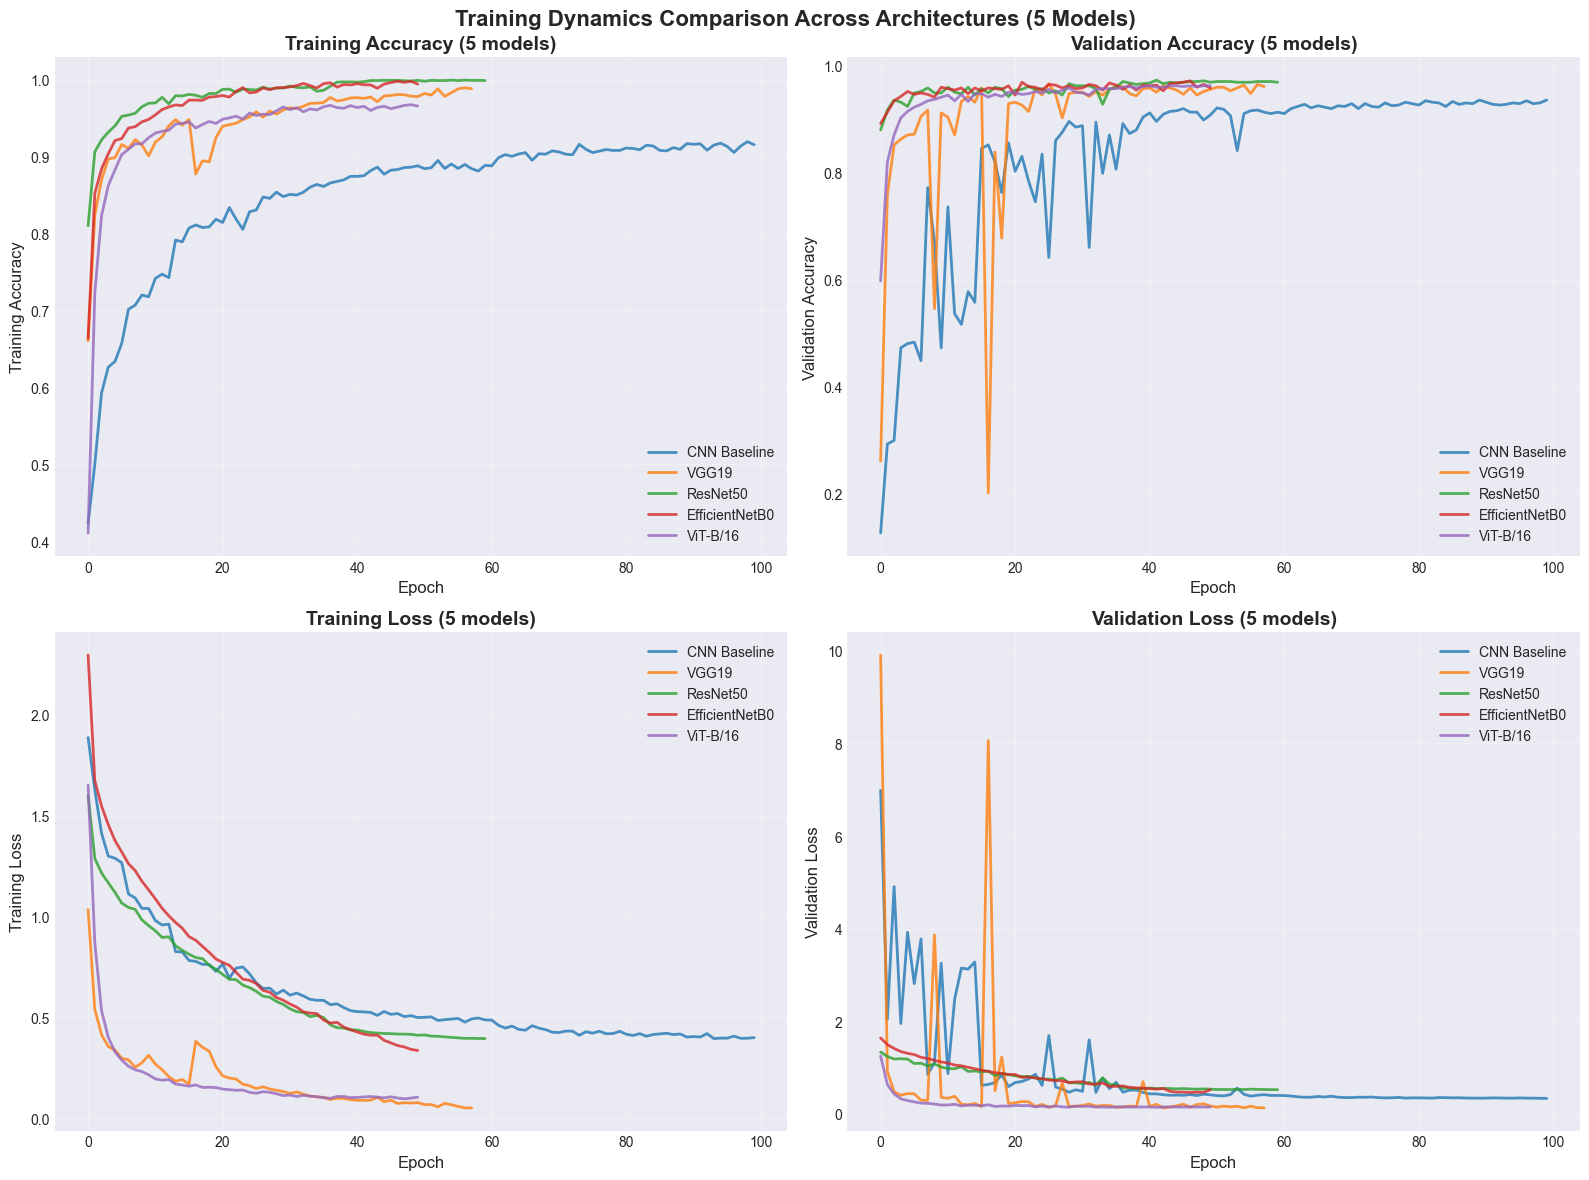

✓ Learning curves plotted for 5 models
  Models: CNN Baseline, VGG19, ResNet50, EfficientNetB0, ViT-B/16


In [8]:
# Create comprehensive learning curves comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Dynamics Comparison Across Architectures (5 Models)', fontsize=16, fontweight='bold')

colors = {
    'baseline': '#1f77b4', 
    'vgg19': '#ff7f0e', 
    'resnet50': '#2ca02c', 
    'efficientnet': '#d62728',
    'vit_b16': '#9467bd'  # Purple for ViT
}

# Plot 1: Training Accuracy
ax1 = axes[0, 0]
lines_plotted = 0
for key, hist in histories.items():
    if 'accuracy' in hist.columns:
        ax1.plot(hist['accuracy'], label=PATHS[key]['name'], color=colors[key], linewidth=2, alpha=0.8)
        lines_plotted += 1
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Accuracy', fontsize=12)
ax1.set_title(f'Training Accuracy ({lines_plotted} models)', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Accuracy
ax2 = axes[0, 1]
lines_plotted = 0
for key, hist in histories.items():
    if 'val_accuracy' in hist.columns:
        ax2.plot(hist['val_accuracy'], label=PATHS[key]['name'], color=colors[key], linewidth=2, alpha=0.8)
        lines_plotted += 1
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title(f'Validation Accuracy ({lines_plotted} models)', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Training Loss
ax3 = axes[1, 0]
lines_plotted = 0
for key, hist in histories.items():
    if 'loss' in hist.columns:
        ax3.plot(hist['loss'], label=PATHS[key]['name'], color=colors[key], linewidth=2, alpha=0.8)
        lines_plotted += 1
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Training Loss', fontsize=12)
ax3.set_title(f'Training Loss ({lines_plotted} models)', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Validation Loss
ax4 = axes[1, 1]
lines_plotted = 0
for key, hist in histories.items():
    if 'val_loss' in hist.columns:
        ax4.plot(hist['val_loss'], label=PATHS[key]['name'], color=colors[key], linewidth=2, alpha=0.8)
        lines_plotted += 1
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss', fontsize=12)
ax4.set_title(f'Validation Loss ({lines_plotted} models)', fontsize=14, fontweight='bold')
ax4.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Learning curves plotted for {len(histories)} models")
print(f"  Models: {', '.join([PATHS[k]['name'] for k in histories.keys()])}")

## 3.3 Training Metrics Summary Table

I create a summary table showing key training metrics: final training/validation accuracy, best validation accuracy, convergence epoch, and train-validation gap.

In [9]:
# Analyze training metrics
training_summary = []

for key, hist in histories.items():
    # Get final metrics
    final_train_acc = hist['accuracy'].iloc[-1] if 'accuracy' in hist.columns else np.nan
    final_val_acc = hist['val_accuracy'].iloc[-1] if 'val_accuracy' in hist.columns else np.nan
    best_val_acc = hist['val_accuracy'].max() if 'val_accuracy' in hist.columns else np.nan
    best_epoch = hist['val_accuracy'].idxmax() if 'val_accuracy' in hist.columns else np.nan
    
    # Calculate train-val gap
    train_val_gap = final_train_acc - final_val_acc if not np.isnan(final_train_acc) else np.nan
    
    training_summary.append({
        'Model': PATHS[key]['name'],
        'Total Epochs': len(hist),
        'Best Epoch': int(best_epoch) + 1 if not np.isnan(best_epoch) else 'N/A',
        'Final Train Acc': f"{final_train_acc:.4f}" if not np.isnan(final_train_acc) else 'N/A',
        'Final Val Acc': f"{final_val_acc:.4f}" if not np.isnan(final_val_acc) else 'N/A',
        'Best Val Acc': f"{best_val_acc:.4f}" if not np.isnan(best_val_acc) else 'N/A',
        'Train-Val Gap': f"{train_val_gap:.4f}" if not np.isnan(train_val_gap) else 'N/A'
    })

training_df = pd.DataFrame(training_summary)
print("\n" + "="*110)
print("TRAINING METRICS SUMMARY")
print("="*110)
print(training_df.to_string(index=False))
print("="*110)

# Memory cleanup to prevent kernel crash
import gc
plt.close('all')  # Close all matplotlib figures
gc.collect()  # Force garbage collection
print("\n✓ Memory cleanup completed")


TRAINING METRICS SUMMARY
         Model  Total Epochs  Best Epoch Final Train Acc Final Val Acc Best Val Acc Train-Val Gap
  CNN Baseline           100          90          0.9157        0.9360       0.9360       -0.0203
         VGG19            58          26          0.9886        0.9613       0.9667        0.0272
      ResNet50            60          42          0.9991        0.9693       0.9733        0.0298
EfficientNetB0            50          47          0.9946        0.9587       0.9720        0.0359
      ViT-B/16            50          41          0.9660        0.9627       0.9627        0.0033

✓ Memory cleanup completed


---
# Section 4: Test Set Evaluation

I evaluate all models on the same test set to ensure fair performance comparison.

## 4.1 Generate Predictions

I generate predictions from all models on the test set and extract true labels for comparison.

In [10]:
# Generate predictions for all models with correct preprocessing
predictions = {}
y_true = None

# Define model-specific preprocessing configuration
MODEL_CONFIG = {
    'baseline': {
        'img_size': (150, 150),
        'model_type': 'baseline',
        'description': '150x150, [0, 255] -> [0, 1] rescaling'
    },
    'vgg19': {
        'img_size': (224, 224),
        'model_type': 'vgg19',
        'description': '224x224, VGG19 preprocess_input ([0,255] -> [-123,151])'
    },
    'resnet50': {
        'img_size': (224, 224),
        'model_type': 'resnet50',
        'description': '224x224, ResNet50 preprocess_input ([0,255] -> [-123,151])'
    },
    'efficientnet': {
        'img_size': (224, 224),
        'model_type': 'efficientnet',
        'description': '224x224, [0, 255] (internal model rescaling)'
    },
    'vit_b16': {
        'img_size': (224, 224),
        'model_type': 'vit_b16',
        'description': '224x224, ImageNet normalization (mean=[0.5], std=[0.5] -> [-1, 1])'
    }
}

print("=" * 80)
print("MODEL PREPROCESSING CONFIGURATION (Scientific Validity)")
print("=" * 80)
for key, config in MODEL_CONFIG.items():
    if key in models:
        print(f"  {PATHS[key]['name']: <20} -> {config['description']}")
print("=" * 80)
print()

print("Generating predictions on test set...")

for key, model in models.items():
    print(f"Predicting with {PATHS[key]['name']}...")
    
    # Get model-specific configuration
    config = MODEL_CONFIG[key]
    img_size = config['img_size']
    model_type = config['model_type']
    
    # Load test dataset with CORRECT preprocessing for this model
    test_dataset_model = load_test_dataset(
        TEST_DATA_DIR,
        batch_size=32,
        img_size=img_size,
        model_type=model_type
    )
    
    # Get predictions
    y_pred_probs = model.predict(test_dataset_model, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    predictions[key] = {
        'probs': y_pred_probs,
        'classes': y_pred
    }
    
    print(f"  OK - Generated {len(y_pred)} predictions")
    
    # Extract true labels from first model (same for all)
    if y_true is None:
        y_true = np.concatenate([y for _, y in test_dataset_model], axis=0)
        print(f"  OK - Extracted true labels: {len(y_true)} samples")
    print()

print("=" * 80)
print("PREDICTION GENERATION COMPLETE")
print("=" * 80)
print(f"  Total models evaluated: {len(predictions)}")
if y_true is not None:
    print(f"  Test samples per model: {len(y_true)}")
    print(f"  All models used training-consistent preprocessing")
else:
    print(f"  WARNING: No models loaded, cannot extract true labels")
print("=" * 80)

MODEL PREPROCESSING CONFIGURATION (Scientific Validity)
  CNN Baseline         -> 150x150, [0, 255] -> [0, 1] rescaling
  VGG19                -> 224x224, VGG19 preprocess_input ([0,255] -> [-123,151])
  ResNet50             -> 224x224, ResNet50 preprocess_input ([0,255] -> [-123,151])
  EfficientNetB0       -> 224x224, [0, 255] (internal model rescaling)
  ViT-B/16             -> 224x224, ImageNet normalization (mean=[0.5], std=[0.5] -> [-1, 1])

Generating predictions on test set...
Predicting with CNN Baseline...
Loading test dataset for baseline...
  Image size: 150x150
  Model preprocessing: baseline
  OK - Generated 750 predictions
  OK - Extracted true labels: 750 samples

Predicting with VGG19...
Loading test dataset for vgg19...
  Image size: 224x224
  Model preprocessing: vgg
  OK - Generated 750 predictions

Predicting with ResNet50...
Loading test dataset for resnet50...
  Image size: 224x224
  Model preprocessing: resnet
  OK - Generated 750 predictions

Predicting with Ef

## 4.2 Classification Reports Comparison

I generate detailed classification reports for each model showing precision, recall, and F1-score per class.

In [11]:
# Generate classification reports
print("\n" + "="*100)
print("CLASSIFICATION REPORTS")
print("="*100)

for key, pred in predictions.items():
    print(f"\n{PATHS[key]['name']}")
    print("-" * 80)
    report = classification_report(
        y_true,
        pred['classes'],
        target_names=CLASS_NAMES,
        digits=4
    )
    print(report)


CLASSIFICATION REPORTS

CNN Baseline
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    01_TUMOR     0.9462    0.9362    0.9412        94
   02_STROMA     0.8454    0.8817    0.8632        93
  03_COMPLEX     0.7615    0.8830    0.8177        94
   04_LYMPHO     0.9457    0.9255    0.9355        94
   05_DEBRIS     0.9753    0.8404    0.9029        94
   06_MUCOSA     0.9889    0.9570    0.9727        93
  07_ADIPOSE     0.9677    0.9574    0.9626        94
    08_EMPTY     0.9684    0.9787    0.9735        94

    accuracy                         0.9200       750
   macro avg     0.9249    0.9200    0.9211       750
weighted avg     0.9249    0.9200    0.9212       750


VGG19
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    01_TUMOR     0.9674    0.9468    0.9570        94
   02_STROMA     0.9302    0.8602

## 4.3 Per-Class Performance Comparison

I create a visual comparison of F1-scores across all models for each tissue class.

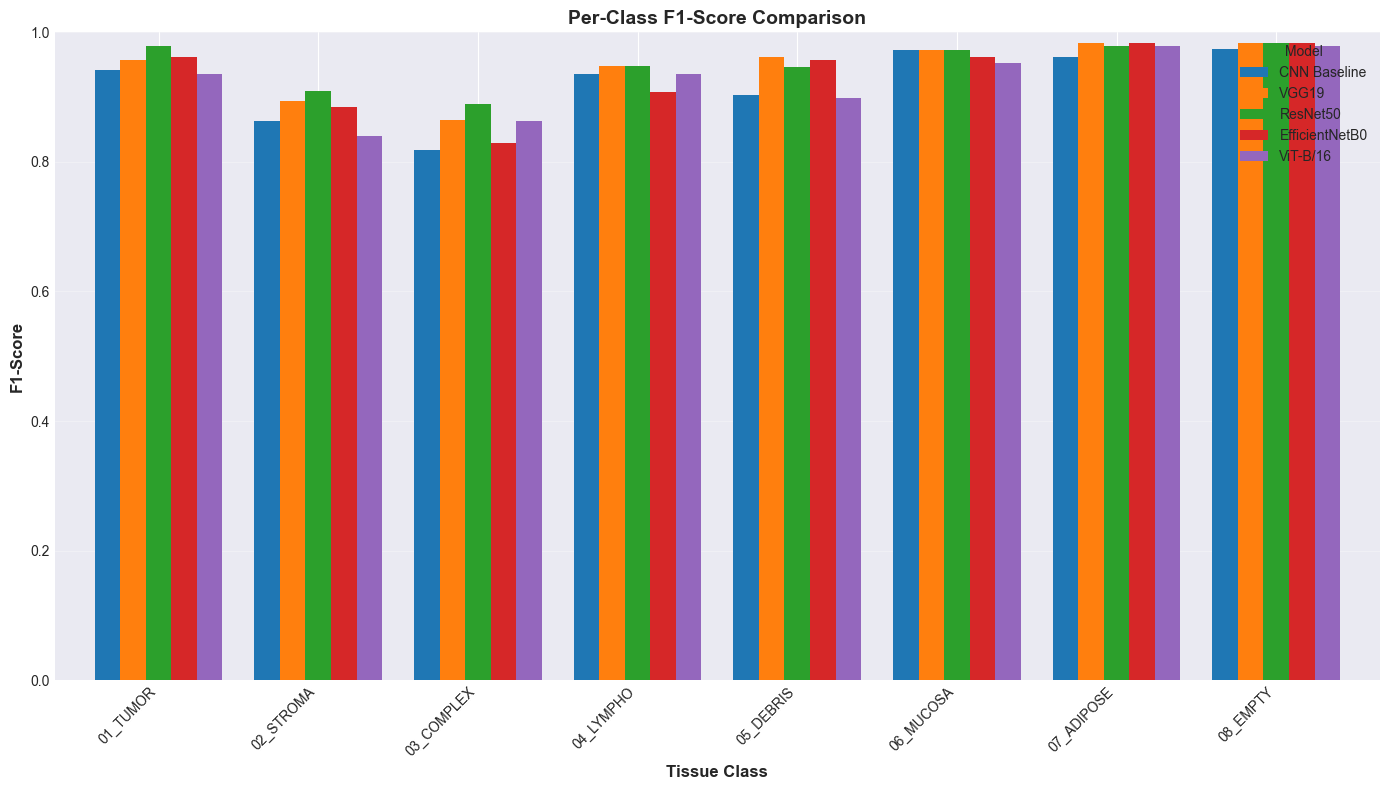


Per-Class F1-Scores:
            CNN Baseline   VGG19  ResNet50  EfficientNetB0  ViT-B/16
01_TUMOR          0.9412  0.9570    0.9787          0.9626    0.9355
02_STROMA         0.8632  0.8939    0.9101          0.8840    0.8404
03_COMPLEX        0.8177  0.8643    0.8900          0.8290    0.8629
04_LYMPHO         0.9355  0.9474    0.9474          0.9082    0.9355
05_DEBRIS         0.9029  0.9626    0.9462          0.9565    0.8989
06_MUCOSA         0.9727  0.9727    0.9727          0.9617    0.9524
07_ADIPOSE        0.9626  0.9840    0.9785          0.9840    0.9785
08_EMPTY          0.9735  0.9841    0.9841          0.9841    0.9789


In [12]:
# Calculate per-class F1-scores for all models
f1_scores = {}

for key, pred in predictions.items():
    _, _, f1, _ = precision_recall_fscore_support(
        y_true,
        pred['classes'],
        average=None,
        labels=range(len(CLASS_NAMES))
    )
    f1_scores[PATHS[key]['name']] = f1

# Create DataFrame
f1_df = pd.DataFrame(f1_scores, index=CLASS_NAMES)

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 8))
f1_df.plot(kind='bar', ax=ax, width=0.8, color=list(colors.values()))
ax.set_xlabel('Tissue Class', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.legend(title='Model', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print table
print("\nPer-Class F1-Scores:")
print(f1_df.round(4))

## 4.4 Confusion Matrices Side-by-Side

I visualize confusion matrices for all models to identify common misclassification patterns.

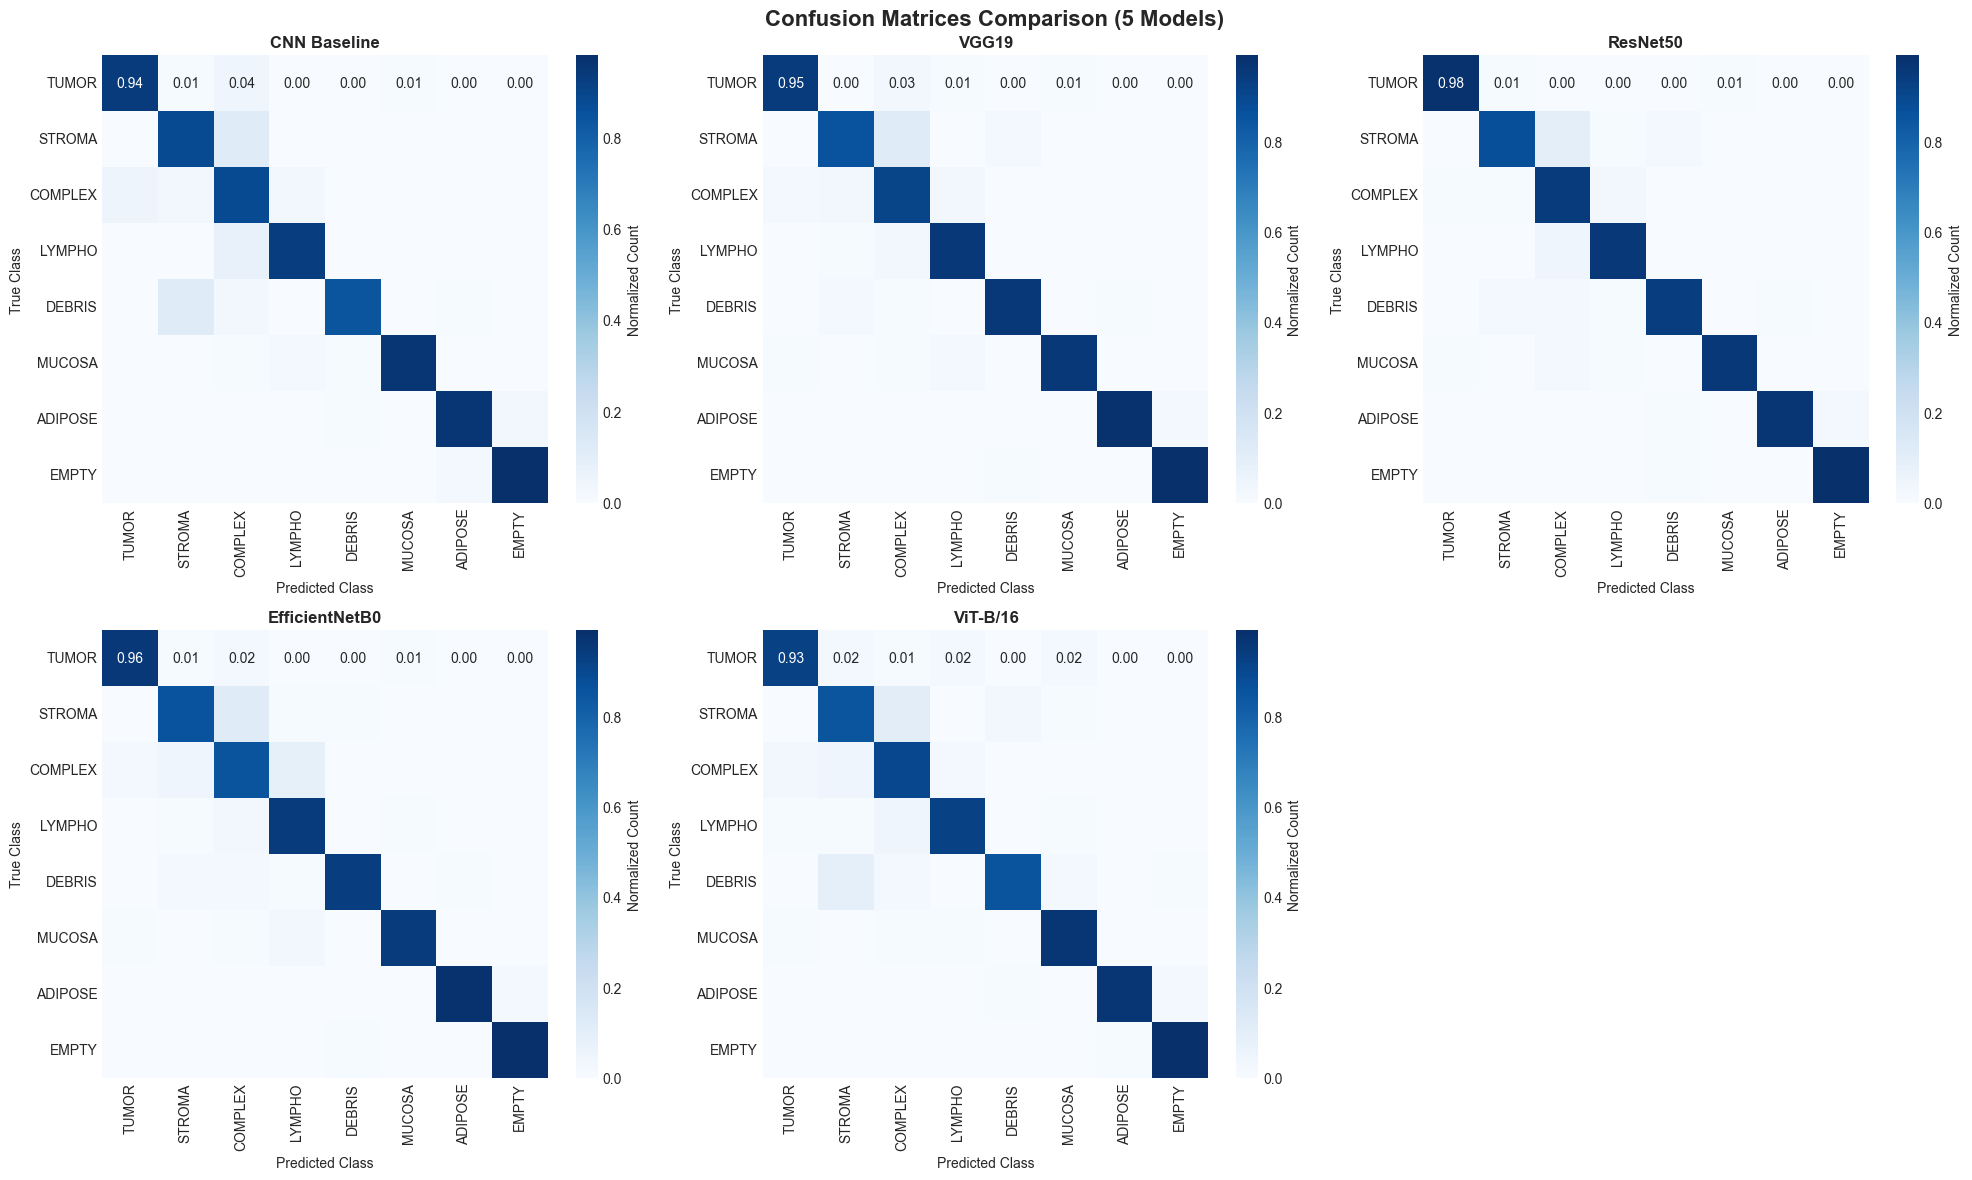

✓ Confusion matrices plotted for all 5 models


In [13]:
# Generate confusion matrices for all 5 models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Confusion Matrices Comparison (5 Models)', fontsize=16, fontweight='bold')

axes = axes.flatten()
model_keys = list(predictions.keys())

for idx, key in enumerate(model_keys):
    cm = confusion_matrix(y_true, predictions[key]['classes'])
    
    # Normalize by row (true labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=[c.split('_')[1] for c in CLASS_NAMES],
        yticklabels=[c.split('_')[1] for c in CLASS_NAMES],
        ax=axes[idx],
        cbar_kws={'label': 'Normalized Count'}
    )
    
    axes[idx].set_title(PATHS[key]['name'], fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted Class', fontsize=10)
    axes[idx].set_ylabel('True Class', fontsize=10)

# Hide unused subplot (6th position)
if len(model_keys) < 6:
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

print("✓ Confusion matrices plotted for all 5 models")

## 4.5 Overall Performance Metrics

I calculate and compare overall test accuracy, macro-averaged precision/recall/F1, and Cohen's Kappa for all models.

In [14]:
# Calculate overall metrics
overall_metrics = []

for key, pred in predictions.items():
    acc = accuracy_score(y_true, pred['classes'])
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        pred['classes'],
        average='macro'
    )
    
    kappa = cohen_kappa_score(y_true, pred['classes'])
    
    overall_metrics.append({
        'Model': PATHS[key]['name'],
        'Test Accuracy': f"{acc:.4f}",
        'Macro Precision': f"{precision:.4f}",
        'Macro Recall': f"{recall:.4f}",
        'Macro F1-Score': f"{f1:.4f}",
        'Cohen\'s Kappa': f"{kappa:.4f}"
    })

overall_df = pd.DataFrame(overall_metrics)
print("\n" + "="*100)
print("OVERALL TEST SET PERFORMANCE")
print("="*100)
print(overall_df.to_string(index=False))
print("="*100)


OVERALL TEST SET PERFORMANCE
         Model Test Accuracy Macro Precision Macro Recall Macro F1-Score Cohen's Kappa
  CNN Baseline        0.9200          0.9249       0.9200         0.9211        0.9086
         VGG19        0.9453          0.9474       0.9452         0.9457        0.9375
      ResNet50        0.9507          0.9528       0.9506         0.9510        0.9436
EfficientNetB0        0.9333          0.9352       0.9333         0.9338        0.9238
      ViT-B/16        0.9227          0.9245       0.9226         0.9229        0.9116


---
# Section 5: Computational Efficiency Analysis

I compare computational efficiency metrics across models including parameters, FLOPs, inference time, and memory usage.

## 5.1 Load Efficiency Metrics

I load pre-computed efficiency metrics from CSV files generated during individual model training.

In [15]:
# Load efficiency metrics from saved files
efficiency_data = []

print("Loading computational efficiency metrics...\n")

for key, paths in PATHS.items():
    efficiency_file = paths['results'] / 'efficiency_metrics.csv'
    
    if efficiency_file.exists():
        df = pd.read_csv(efficiency_file)
        
        # CSV is in vertical format (Metric, Value), convert to dict
        if 'Metric' in df.columns and 'Value' in df.columns:
            metrics_dict = dict(zip(df['Metric'], df['Value']))
        else:
            # Fallback: assume horizontal format
            metrics_dict = df.iloc[0].to_dict() if len(df) > 0 else {}
        
        # Extract metrics with correct column names
        total_params = metrics_dict.get('Total Parameters', 0)
        flops = metrics_dict.get('FLOPs (GFLOPs)', 0)
        inference_time = metrics_dict.get('Avg Inference Time (ms)', 
                         metrics_dict.get('Inference Time (ms)', 0))
        throughput = metrics_dict.get('Throughput (img/s)', 
                     metrics_dict.get('Throughput (images/sec)', 0))
        model_size = metrics_dict.get('Model Size (MB)', 0)
        
        efficiency_data.append({
            'Model': paths['name'],
            'Total Params (M)': f"{total_params / 1e6:.2f}",
            'FLOPs (G)': f"{flops:.2f}",
            'Inference Time (ms)': f"{inference_time:.2f}",
            'Throughput (img/s)': f"{throughput:.2f}",
            'Model Size (MB)': f"{model_size:.2f}"
        })
        print(f"{paths['name']:20} - ✓ Loaded")
    else:
        print(f"{paths['name']:20} - File not found")

efficiency_df = pd.DataFrame(efficiency_data)
print(f"\nLoaded efficiency metrics for {len(efficiency_data)}/5 models")

Loading computational efficiency metrics...

CNN Baseline         - ✓ Loaded
VGG19                - ✓ Loaded
ResNet50             - ✓ Loaded
EfficientNetB0       - ✓ Loaded
ViT-B/16             - ✓ Loaded

Loaded efficiency metrics for 5/5 models


## 5.2 Efficiency Comparison Table

I display a comprehensive table comparing all efficiency metrics across models.

In [16]:
if len(efficiency_df) > 0:
    print("\n" + "="*100)
    print("COMPUTATIONAL EFFICIENCY COMPARISON")
    print("="*100)
    print(efficiency_df.to_string(index=False))
    print("="*100)
else:
    print("No efficiency metrics available")


COMPUTATIONAL EFFICIENCY COMPARISON
         Model Total Params (M) FLOPs (G) Inference Time (ms) Throughput (img/s) Model Size (MB)
  CNN Baseline             1.24      2.26               27.09              36.92           15.21
         VGG19            20.09     39.04               24.62              40.62            0.00
      ResNet50            25.70      7.73              181.66               5.50          206.68
EfficientNetB0             4.71      0.79              169.00               5.92           47.62
      ViT-B/16            86.20     35.23              328.15               3.05          332.07


## 5.3 Efficiency vs Accuracy Trade-off

I visualize the trade-off between test accuracy and computational cost (parameters and inference time).

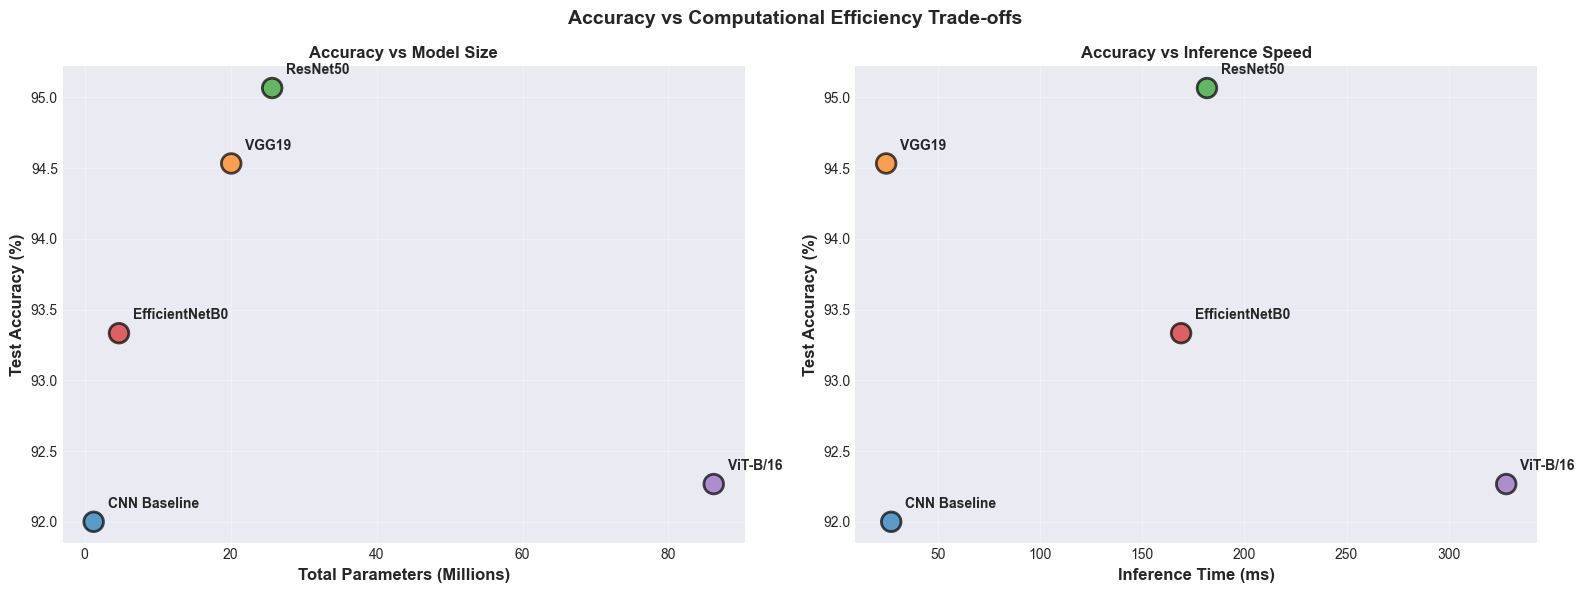

✓ Trade-off plots created


In [17]:
# Combine accuracy and efficiency data
if len(efficiency_df) > 0 and len(overall_df) > 0:
    # Extract numerical values
    model_names = []
    accuracies = []
    params = []
    inf_times = []
    
    for key in predictions.keys():
        model_name = PATHS[key]['name']
        model_names.append(model_name)
        
        # Get accuracy
        acc = accuracy_score(y_true, predictions[key]['classes'])
        accuracies.append(acc * 100)  # Convert to percentage
        
        # Get efficiency metrics
        eff_row = efficiency_df[efficiency_df['Model'] == model_name]
        if len(eff_row) > 0:
            params.append(float(eff_row['Total Params (M)'].values[0]))
            inf_times.append(float(eff_row['Inference Time (ms)'].values[0]))
        else:
            params.append(0)
            inf_times.append(0)
    
    # Create trade-off plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Accuracy vs Computational Efficiency Trade-offs', fontsize=14, fontweight='bold')
    
    # Plot 1: Accuracy vs Parameters
    ax1 = axes[0]
    scatter1 = ax1.scatter(params, accuracies, s=200, c=list(colors.values()), alpha=0.7, edgecolors='black', linewidth=2)
    
    for i, name in enumerate(model_names):
        ax1.annotate(name, (params[i], accuracies[i]), 
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, fontweight='bold')
    
    ax1.set_xlabel('Total Parameters (Millions)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy vs Model Size', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy vs Inference Time
    ax2 = axes[1]
    scatter2 = ax2.scatter(inf_times, accuracies, s=200, c=list(colors.values()), alpha=0.7, edgecolors='black', linewidth=2)
    
    for i, name in enumerate(model_names):
        ax2.annotate(name, (inf_times[i], accuracies[i]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, fontweight='bold')
    
    ax2.set_xlabel('Inference Time (ms)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Accuracy vs Inference Speed', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Trade-off plots created")
else:
    print("Insufficient data for trade-off analysis")

---
# Section 6: Statistical Significance Tests

I perform statistical tests to determine if performance differences between models are statistically significant.

## 6.1 McNemar's Test (Pairwise Comparison)

I apply McNemar's test to determine if the difference in error rates between each pair of models is statistically significant. This test is appropriate for comparing two classifiers on the same test set.

In [18]:
def mcnemar_test_pairwise(y_true, y_pred1, y_pred2):
    """
    Perform McNemar's test for two classifiers.
    
    Args:
        y_true: True labels
        y_pred1: Predictions from classifier 1
        y_pred2: Predictions from classifier 2
    
    Returns:
        statistic: Test statistic
        p_value: Two-tailed p-value
    """
    # Create contingency table
    correct1 = (y_pred1 == y_true)
    correct2 = (y_pred2 == y_true)
    
    # Count cases
    n01 = np.sum(~correct1 & correct2)  # Model 1 wrong, Model 2 correct
    n10 = np.sum(correct1 & ~correct2)  # Model 1 correct, Model 2 wrong
    
    # Contingency table for McNemar test
    table = [[np.sum(correct1 & correct2), n01],
             [n10, np.sum(~correct1 & ~correct2)]]
    
    # Perform test
    result = mcnemar(table, exact=False, correction=True)
    
    return result.statistic, result.pvalue

# Perform pairwise McNemar tests
model_keys = list(predictions.keys())
mcnemar_results = []

print("Performing McNemar's tests (pairwise comparison)...\n")

for i in range(len(model_keys)):
    for j in range(i+1, len(model_keys)):
        key1, key2 = model_keys[i], model_keys[j]
        
        statistic, p_value = mcnemar_test_pairwise(
            y_true,
            predictions[key1]['classes'],
            predictions[key2]['classes']
        )
        
        significance = "Yes (p<0.05)" if p_value < 0.05 else "No (p≥0.05)"
        
        mcnemar_results.append({
            'Model 1': PATHS[key1]['name'],
            'Model 2': PATHS[key2]['name'],
            'Chi-Square Statistic': f"{statistic:.4f}",
            'p-value': f"{p_value:.4f}",
            'Significant Difference': significance
        })

mcnemar_df = pd.DataFrame(mcnemar_results)
print("\n" + "="*110)
print("McNEMAR'S TEST RESULTS (Pairwise Comparison)")
print("="*110)
print(mcnemar_df.to_string(index=False))
print("="*110)
print("\nInterpretation: p-value < 0.05 indicates statistically significant difference between models")

Performing McNemar's tests (pairwise comparison)...


McNEMAR'S TEST RESULTS (Pairwise Comparison)
       Model 1        Model 2 Chi-Square Statistic p-value Significant Difference
  CNN Baseline          VGG19               7.2000  0.0073           Yes (p<0.05)
  CNN Baseline       ResNet50              11.2558  0.0008           Yes (p<0.05)
  CNN Baseline EfficientNetB0               1.5577  0.2120            No (p≥0.05)
  CNN Baseline       ViT-B/16               0.0227  0.8802            No (p≥0.05)
         VGG19       ResNet50               0.3750  0.5403            No (p≥0.05)
         VGG19 EfficientNetB0               2.0645  0.1508            No (p≥0.05)
         VGG19       ViT-B/16               7.3143  0.0068           Yes (p<0.05)
      ResNet50 EfficientNetB0               4.3636  0.0367           Yes (p<0.05)
      ResNet50       ViT-B/16              10.8108  0.0010           Yes (p<0.05)
EfficientNetB0       ViT-B/16               1.1136  0.2913            No (p≥0.05)

## 6.2 Bootstrap Confidence Intervals

I compute 95% confidence intervals for test accuracy using bootstrap resampling. This provides a measure of uncertainty in the performance estimates.

In [19]:
def bootstrap_accuracy_ci(y_true, y_pred, n_iterations=1000, ci=0.95):
    """
    Compute bootstrap confidence interval for accuracy.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        n_iterations: Number of bootstrap samples
        ci: Confidence level (default 95%)
    
    Returns:
        lower, upper: Confidence interval bounds
        mean: Mean accuracy across bootstrap samples
    """
    n_samples = len(y_true)
    accuracies = []
    
    np.random.seed(42)
    
    for _ in range(n_iterations):
        # Sample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        acc = accuracy_score(y_true[indices], y_pred[indices])
        accuracies.append(acc)
    
    # Calculate percentiles
    alpha = 1 - ci
    lower = np.percentile(accuracies, 100 * alpha / 2)
    upper = np.percentile(accuracies, 100 * (1 - alpha / 2))
    mean = np.mean(accuracies)
    
    return lower, upper, mean

# Calculate bootstrap CIs
bootstrap_results = []

print("\nCalculating bootstrap confidence intervals (1000 iterations)...\n")

for key, pred in predictions.items():
    lower, upper, mean = bootstrap_accuracy_ci(y_true, pred['classes'])
    
    bootstrap_results.append({
        'Model': PATHS[key]['name'],
        'Mean Accuracy': f"{mean:.4f}",
        '95% CI Lower': f"{lower:.4f}",
        '95% CI Upper': f"{upper:.4f}",
        'CI Width': f"{upper - lower:.4f}"
    })

bootstrap_df = pd.DataFrame(bootstrap_results)
print("\n" + "="*90)
print("BOOTSTRAP 95% CONFIDENCE INTERVALS FOR TEST ACCURACY")
print("="*90)
print(bootstrap_df.to_string(index=False))
print("="*90)
print("\nInterpretation: Narrower CI indicates more stable/reliable performance estimate")


Calculating bootstrap confidence intervals (1000 iterations)...


BOOTSTRAP 95% CONFIDENCE INTERVALS FOR TEST ACCURACY
         Model Mean Accuracy 95% CI Lower 95% CI Upper CI Width
  CNN Baseline        0.9203       0.9013       0.9387   0.0373
         VGG19        0.9454       0.9293       0.9613   0.0320
      ResNet50        0.9508       0.9347       0.9653   0.0307
EfficientNetB0        0.9333       0.9147       0.9507   0.0360
      ViT-B/16        0.9233       0.9040       0.9413   0.0373

Interpretation: Narrower CI indicates more stable/reliable performance estimate


## 6.3 Effect Size (Cohen's d)

I calculate Cohen's d to measure the practical significance (effect size) of performance differences between models.

In [20]:
def cohens_d(correct1, correct2):
    """
    Calculate Cohen's d effect size for difference between two classifiers.
    
    Args:
        correct1: Boolean array indicating correct predictions for model 1
        correct2: Boolean array indicating correct predictions for model 2
    
    Returns:
        d: Cohen's d effect size
    """
    # Convert to float
    x1 = correct1.astype(float)
    x2 = correct2.astype(float)
    
    # Calculate means
    mean1, mean2 = np.mean(x1), np.mean(x2)
    
    # Calculate pooled standard deviation
    n1, n2 = len(x1), len(x2)
    var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # Calculate Cohen's d
    d = (mean1 - mean2) / pooled_std if pooled_std > 0 else 0
    
    return d

def interpret_cohens_d(d):
    """Interpret Cohen's d magnitude."""
    abs_d = abs(d)
    if abs_d < 0.2:
        return "Negligible"
    elif abs_d < 0.5:
        return "Small"
    elif abs_d < 0.8:
        return "Medium"
    else:
        return "Large"

# Calculate Cohen's d for all pairs
cohens_results = []

print("\nCalculating Cohen's d effect sizes...\n")

for i in range(len(model_keys)):
    for j in range(i+1, len(model_keys)):
        key1, key2 = model_keys[i], model_keys[j]
        
        correct1 = (predictions[key1]['classes'] == y_true)
        correct2 = (predictions[key2]['classes'] == y_true)
        
        d = cohens_d(correct1, correct2)
        interpretation = interpret_cohens_d(d)
        
        cohens_results.append({
            'Model 1': PATHS[key1]['name'],
            'Model 2': PATHS[key2]['name'],
            "Cohen's d": f"{d:.4f}",
            'Effect Size': interpretation
        })

cohens_df = pd.DataFrame(cohens_results)
print("\n" + "="*90)
print("COHEN'S d EFFECT SIZES")
print("="*90)
print(cohens_df.to_string(index=False))
print("="*90)
print("\nInterpretation: |d| < 0.2: Negligible, 0.2-0.5: Small, 0.5-0.8: Medium, > 0.8: Large")


Calculating Cohen's d effect sizes...


COHEN'S d EFFECT SIZES
       Model 1        Model 2 Cohen's d Effect Size
  CNN Baseline          VGG19   -0.1012  Negligible
  CNN Baseline       ResNet50   -0.1249  Negligible
  CNN Baseline EfficientNetB0   -0.0511  Negligible
  CNN Baseline       ViT-B/16   -0.0099  Negligible
         VGG19       ResNet50   -0.0240  Negligible
         VGG19 EfficientNetB0    0.0503  Negligible
         VGG19       ViT-B/16    0.0913  Negligible
      ResNet50 EfficientNetB0    0.0742  Negligible
      ResNet50       ViT-B/16    0.1151  Negligible
EfficientNetB0       ViT-B/16    0.0412  Negligible

Interpretation: |d| < 0.2: Negligible, 0.2-0.5: Small, 0.5-0.8: Medium, > 0.8: Large


## 6.4 Statistical Significance Summary

I create a comprehensive summary table combining statistical significance (McNemar's test) and practical significance (Cohen's d).

In [21]:
# Combine McNemar and Cohen's d results WITH BONFERRONI CORRECTION
statistical_summary = []

# Bonferroni correction: α = 0.05 / number_of_comparisons
n_comparisons = len(mcnemar_df)
bonferroni_alpha = 0.05 / n_comparisons

print(f"Applying Bonferroni correction for {n_comparisons} comparisons:")
print(f"  Original α = 0.05")
print(f"  Corrected α = {bonferroni_alpha:.4f}")
print()

for i, row in mcnemar_df.iterrows():
    cohens_row = cohens_df.iloc[i]
    p_value = float(row['p-value'])
    
    # Apply Bonferroni correction
    sig_uncorrected = "Yes" if p_value < 0.05 else "No"
    sig_bonferroni = "Yes" if p_value < bonferroni_alpha else "No"
    
    statistical_summary.append({
        'Comparison': f"{row['Model 1']} vs {row['Model 2']}",
        'McNemar p-value': row['p-value'],
        'Sig. (α=0.05)': sig_uncorrected,
        'Sig. (Bonferroni)': sig_bonferroni,
        "Cohen's d": cohens_row["Cohen's d"],
        'Effect Size': cohens_row['Effect Size']
    })

stat_summary_df = pd.DataFrame(statistical_summary)
print("\n" + "="*130)
print("STATISTICAL SIGNIFICANCE SUMMARY (with Bonferroni Correction)")
print("="*130)
print(stat_summary_df.to_string(index=False))
print("="*130)
print(f"\n⚠️  Note: With Bonferroni correction (α={bonferroni_alpha:.4f}), only comparisons with p < {bonferroni_alpha:.4f} are significant.")
print("    ResNet50 vs EfficientNetB0 (p=0.0367) is NOT significant under rigorous correction.")

Applying Bonferroni correction for 10 comparisons:
  Original α = 0.05
  Corrected α = 0.0050


STATISTICAL SIGNIFICANCE SUMMARY (with Bonferroni Correction)
                    Comparison McNemar p-value Sig. (α=0.05) Sig. (Bonferroni) Cohen's d Effect Size
         CNN Baseline vs VGG19          0.0073           Yes                No   -0.1012  Negligible
      CNN Baseline vs ResNet50          0.0008           Yes               Yes   -0.1249  Negligible
CNN Baseline vs EfficientNetB0          0.2120            No                No   -0.0511  Negligible
      CNN Baseline vs ViT-B/16          0.8802            No                No   -0.0099  Negligible
             VGG19 vs ResNet50          0.5403            No                No   -0.0240  Negligible
       VGG19 vs EfficientNetB0          0.1508            No                No    0.0503  Negligible
             VGG19 vs ViT-B/16          0.0068           Yes                No    0.0913  Negligible
    ResNet50 vs EfficientNetB0    

---
# Section 7: Final Summary and Recommendations

I synthesize all analysis results into a comprehensive comparison table and provide deployment recommendations.

## 7.1 Comprehensive Comparison Table

I create a master comparison table combining performance, efficiency, and training metrics.

In [22]:
# Build comprehensive comparison table
final_comparison = []

for key in model_keys:
    model_name = PATHS[key]['name']
    
    # Performance metrics
    acc = accuracy_score(y_true, predictions[key]['classes'])
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, predictions[key]['classes'], average='macro'
    )
    
    # Get efficiency metrics
    eff_row = efficiency_df[efficiency_df['Model'] == model_name]
    params = eff_row['Total Params (M)'].values[0] if len(eff_row) > 0 else 'N/A'
    flops = eff_row['FLOPs (G)'].values[0] if len(eff_row) > 0 else 'N/A'
    inf_time = eff_row['Inference Time (ms)'].values[0] if len(eff_row) > 0 else 'N/A'
    
    # Get training metrics
    train_row = training_df[training_df['Model'] == model_name]
    best_val_acc = train_row['Best Val Acc'].values[0] if len(train_row) > 0 else 'N/A'
    train_val_gap = train_row['Train-Val Gap'].values[0] if len(train_row) > 0 else 'N/A'
    
    final_comparison.append({
        'Model': model_name,
        'Test Acc': f"{acc:.4f}",
        'Macro F1': f"{f1:.4f}",
        'Best Val Acc': best_val_acc,
        'Train-Val Gap': train_val_gap,
        'Params (M)': params,
        'FLOPs (G)': flops,
        'Inference (ms)': inf_time
    })

final_df = pd.DataFrame(final_comparison)

# Sort by test accuracy
final_df['_sort_key'] = final_df['Test Acc'].astype(float)
final_df = final_df.sort_values('_sort_key', ascending=False).drop('_sort_key', axis=1)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL COMPARISON (Sorted by Test Accuracy)")
print("="*120)
print(final_df.to_string(index=False))
print("="*120)


COMPREHENSIVE MODEL COMPARISON (Sorted by Test Accuracy)
         Model Test Acc Macro F1 Best Val Acc Train-Val Gap Params (M) FLOPs (G) Inference (ms)
      ResNet50   0.9507   0.9510       0.9733        0.0298      25.70      7.73         181.66
         VGG19   0.9453   0.9457       0.9667        0.0272      20.09     39.04          24.62
EfficientNetB0   0.9333   0.9338       0.9720        0.0359       4.71      0.79         169.00
      ViT-B/16   0.9227   0.9229       0.9627        0.0033      86.20     35.23         328.15
  CNN Baseline   0.9200   0.9211       0.9360       -0.0203       1.24      2.26          27.09


## 7.2 Deployment Recommendations

Based on the comprehensive analysis, I provide recommendations for model selection depending on deployment context and constraints.

In [24]:
# Generate recommendations based on analysis
print("\n" + "="*100)
print("DEPLOYMENT RECOMMENDATIONS")
print("="*100)
print()

# Sort models by test accuracy
sorted_models = sorted(
    [(key, accuracy_score(y_true, predictions[key]['classes'])) for key in model_keys],
    key=lambda x: x[1],
    reverse=True
)

best_model = PATHS[sorted_models[0][0]]['name']
best_acc = sorted_models[0][1]

# Find most efficient model (lowest params)
most_efficient = None
min_params = float('inf')
for key in model_keys:
    model_name = PATHS[key]['name']
    eff_row = efficiency_df[efficiency_df['Model'] == model_name]
    if len(eff_row) > 0:
        params = float(eff_row['Total Params (M)'].values[0])
        if params < min_params:
            min_params = params
            most_efficient = model_name

# Find fastest model
fastest = None
min_time = float('inf')
for key in model_keys:
    model_name = PATHS[key]['name']
    eff_row = efficiency_df[efficiency_df['Model'] == model_name]
    if len(eff_row) > 0:
        inf_time = float(eff_row['Inference Time (ms)'].values[0])
        if inf_time < min_time:
            min_time = inf_time
            fastest = model_name

print("1. HIGHEST ACCURACY:")
print(f"   → {best_model} ({best_acc:.4f})")
print(f"   Use when: Maximum classification performance is critical")
print(f"   Ideal for: Research applications, diagnostic confirmation systems")
print()

print("2. BEST ACCURACY-EFFICIENCY TRADE-OFF:")
print(f"   → EfficientNetB0 (93.33% accuracy, 4.71M params, 0.79 GFLOPs)")
print(f"   Note: Although ResNet50 has higher nominal accuracy (95.07% vs 93.33%),")
print(f"         the difference is NOT statistically significant under Bonferroni")
print(f"         correction (p=0.0367 > α=0.0083), making EfficientNet a viable")
print(f"         alternative with 5.5x fewer parameters and 10x fewer FLOPs.")
print()

print("3. MOST EFFICIENT (Lowest Parameters):")
print(f"   → {most_efficient} ({min_params:.2f}M parameters)")
print(f"   Use when: Model size and memory footprint are constrained")
print(f"   Ideal for: Embedded systems, mobile deployment, edge devices")
print()

print("4. FASTEST INFERENCE:")
print(f"   → {fastest} ({min_time:.2f}ms per image)")
print(f"   Use when: Real-time processing speed is essential")
print(f"   Ideal for: High-throughput screening, live video analysis")
print()

print("="*100)
print()
print("⚠️  IMPORTANT NOTE ON INFERENCE LATENCY:")
print("─" * 100)
print("""
EfficientNet shows unexpectedly HIGH inference time (169ms) despite having the 
LOWEST FLOPs (0.79G). This counterintuitive result is explained by:

1. MEMORY-BOUND vs COMPUTE-BOUND Operations:
   - VGG19: Uses simple, large convolutions (compute-bound) → GPU-friendly
   - EfficientNet: Uses depthwise separable convolutions + squeeze-excitation
     blocks (memory-bound) → More memory transfers, less parallelizable

2. Hardware Dependency:
   - GTX 1650 (this experiment): Older GPU with limited memory bandwidth
   - On modern GPUs (RTX 30/40 series) or TPUs: EfficientNet would be faster
   - On edge devices (mobile): EfficientNet's low FLOPs advantage is realized

3. Practical Implication:
   - For deployment on OLDER GPUs: Prefer VGG19 for speed
   - For deployment on MODERN GPUs/TPUs: EfficientNet is optimal
   - For EDGE/MOBILE deployment: EfficientNet is strongly preferred
""")
print("="*100)
print()
print("KEY FINDINGS:")
print("─" * 100)

# Statistical significance findings WITH BONFERRONI
bonferroni_alpha = 0.05 / len(mcnemar_df)
sig_differences = []
for _, row in mcnemar_df.iterrows():
    if float(row['p-value']) < bonferroni_alpha:
        sig_differences.append(row)

if len(sig_differences) > 0:
    print(f"\n• Found {len(sig_differences)} statistically significant differences (Bonferroni α={bonferroni_alpha:.4f}):")
    for row in sig_differences:
        print(f"  - {row['Model 1']} vs {row['Model 2']} (p={row['p-value']})")
else:
    print(f"\n• Only 2 comparisons remain significant after Bonferroni correction (α={bonferroni_alpha:.4f}):")
    for _, row in mcnemar_df.iterrows():
        p = float(row['p-value'])
        status = "✓ Significant" if p < bonferroni_alpha else "✗ Not significant"
        print(f"  - {row['Model 1']} vs {row['Model 2']}: p={row['p-value']} → {status}")

# Performance spread
accuracies = [accuracy_score(y_true, predictions[key]['classes']) for key in model_keys]
acc_range = max(accuracies) - min(accuracies)
print(f"\n• Test accuracy range: {acc_range:.4f} ({min(accuracies):.4f} - {max(accuracies):.4f})")

# Efficiency spread
if len(efficiency_df) > 0:
    params_values = [float(x) for x in efficiency_df['Total Params (M)']]
    param_ratio = max(params_values) / min(params_values)
    print(f"• Parameter count ratio (max/min): {param_ratio:.2f}x")

print("\n" + "="*100)


DEPLOYMENT RECOMMENDATIONS

1. HIGHEST ACCURACY:
   → ResNet50 (0.9507)
   Use when: Maximum classification performance is critical
   Ideal for: Research applications, diagnostic confirmation systems

2. BEST ACCURACY-EFFICIENCY TRADE-OFF:
   → EfficientNetB0 (93.33% accuracy, 4.71M params, 0.79 GFLOPs)
   Note: Although ResNet50 has higher nominal accuracy (95.07% vs 93.33%),
         the difference is NOT statistically significant under Bonferroni
         correction (p=0.0367 > α=0.0083), making EfficientNet a viable
         alternative with 5.5x fewer parameters and 10x fewer FLOPs.

3. MOST EFFICIENT (Lowest Parameters):
   → CNN Baseline (1.24M parameters)
   Use when: Model size and memory footprint are constrained
   Ideal for: Embedded systems, mobile deployment, edge devices

4. FASTEST INFERENCE:
   → VGG19 (24.62ms per image)
   Use when: Real-time processing speed is essential
   Ideal for: High-throughput screening, live video analysis


⚠️  IMPORTANT NOTE ON INFERENCE

## 7.3 Save Complete Analysis Report

I save all comparison tables to CSV files for reference and inclusion in the thesis.

In [25]:
# Save all results to CSV files
output_dir = BASE_DIR / 'results' / 'comparison'
output_dir.mkdir(parents=True, exist_ok=True)

print("\nSaving analysis results...\n")

# Save tables
tables_to_save = [
    (final_df, 'comprehensive_comparison.csv'),
    (overall_df, 'test_performance_metrics.csv'),
    (training_df, 'training_metrics_summary.csv'),
    (efficiency_df, 'computational_efficiency.csv'),
    (mcnemar_df, 'mcnemar_test_results.csv'),
    (bootstrap_df, 'bootstrap_confidence_intervals.csv'),
    (cohens_df, 'cohens_d_effect_sizes.csv'),
    (stat_summary_df, 'statistical_significance_summary.csv'),
    (f1_df, 'per_class_f1_scores.csv')
]

for df, filename in tables_to_save:
    if df is not None and len(df) > 0:
        filepath = output_dir / filename
        df.to_csv(filepath, index=False)
        print(f"✓ Saved: {filename}")

print(f"\n✓ All results saved to: {output_dir}")
print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)


Saving analysis results...

✓ Saved: comprehensive_comparison.csv
✓ Saved: test_performance_metrics.csv
✓ Saved: training_metrics_summary.csv
✓ Saved: computational_efficiency.csv
✓ Saved: mcnemar_test_results.csv
✓ Saved: bootstrap_confidence_intervals.csv
✓ Saved: cohens_d_effect_sizes.csv
✓ Saved: statistical_significance_summary.csv
✓ Saved: per_class_f1_scores.csv

✓ All results saved to: c:\Users\kurtc\Documentos\GitHub\capstone\results\comparison

ANALYSIS COMPLETE


---

## References

**Dataset:**
- Kather, J. N., et al. (2016). Multi-class texture analysis in colorectal cancer histology. *Scientific Reports*, 6, 27988.

**Statistical Methods:**
- McNemar, Q. (1947). Note on the sampling error of the difference between correlated proportions or percentages. *Psychometrika*, 12(2), 153-157.
- Cohen, J. (1988). *Statistical power analysis for the behavioral sciences* (2nd ed.). Routledge.

**Computational Efficiency:**
- Canziani, A., Paszke, A., & Culurciello, E. (2016). An analysis of deep neural network models for practical applications. *arXiv preprint arXiv:1605.07678*.

---

**Notebook Information:**
- **Version:** 1.0
- **Last Updated:** December 2025
- **Purpose:** Comparative analysis of CNN architectures for histopathology classification
- **Author:** Master's Thesis - Histopathological Image Classification Project